# Experiments with a Perceptron Model: - CIFAR Dataset

In an earlier notebook, I worked with an example to detect if a given image is of a cat or not. In this notebook, I will show that we can generalize and train the perceptron algorithm (logistic regression) to detect various other classes of the object. CIFAR dataset contain 50K+ images of 10 classes of objects. 

In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pickle
import math

In [150]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) #Set default plot sizes
plt.rcParams['image.interpolation'] = 'nearest' #Use nearest neighbor for rendering

In [151]:
# Allowing notebooks to reload external python modules
# Details: http://stackoverflow.com/questions/1907993/aut
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Preparation
Use pickle to unpack to cifar data

In [152]:
def unpickle(file):
    fo = open(file, 'rb')
    data = pickle.load(fo, encoding = 'bytes')
    return data

### Importing the data

In [153]:
file = 'cifar/data_batch_1'
u = unpickle(file)

x = u[b'data'].reshape(10000,3,32,32).transpose(0,2,3,1).astype('float')
y = np.array(u[b'labels'])

### Visualizing the data

In [154]:
classes = {"plane":0,'car':1,'bird':2,'cat':3,'deer':4,'dog':5,'frog':6,'horse':7,'ship':9,'truck':10}
number_of_samples = 7
number_of_classes = len(classes)
class_of_interest = "plane"
idclass = classes[class_of_interest]

Let us say that we are interested to train a perceptron model to detect planes. Here are some images of planes in the dataset

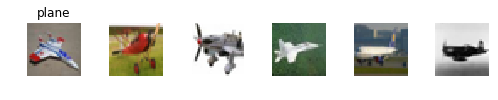

In [155]:
y_sample = np.where(y == idclass)
y_idx = y_sample[0][1:number_of_samples]
offset = 1

for i in y_idx:

    plt.subplot(number_of_samples,number_of_samples,offset)
    plt.imshow(x[i].astype('uint8'))
    if(offset == 1):
        plt.title(class_of_interest)
    offset= offset + 1
    plt.axis('off')

plt.show()

We will consider all other classes as examples of "not a plane". Here are some examples of objects that are not planes. The objects here are trucks, car and animals.

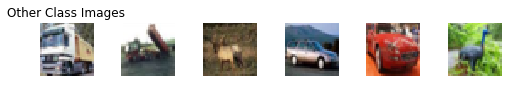

In [156]:
y_otherclass = np.where(y!=idclass)
y_idx = y_otherclass[0][1:number_of_samples]

offset = 1
for i in y_idx:
    plt.subplot(number_of_samples,number_of_samples,offset)
    plt.imshow(x[i].astype('uint8'))
    if(offset == 1):
        plt.title("Other Class Images")
    offset= offset + 1
    plt.axis('off')

plt.show()

In [157]:
x_dataset = x
y_dataset = np.zeros(len(y))
y_dataset[y == idclass] = 1

In [158]:
from sklearn.model_selection import train_test_split

In [159]:
xtrain, xtest, ytrain, ytest = train_test_split(x_dataset, y_dataset, test_size = 0.2)

lets us just confirm the shape of the various arrays and number of inputs

In [160]:
print("# Training Images:", np.shape(xtrain)[0])
print("Dimensions of training image:", np.shape(xtrain)[1:4])
print("# Test Images:", np.shape(xtest)[0])
print("Dimensions of test image:", np.shape(xtest)[1:4])

# Training Images: 8000
Dimensions of training image: (32, 32, 3)
# Test Images: 2000
Dimensions of test image: (32, 32, 3)


We will use vectorized operations here, so let us flatten the matrices

In [161]:
x_train_vector = xtrain.reshape(xtrain.shape[0],-1).T
x_test_vector = xtest.reshape(xtest.shape[0],-1).T

Confirm the shape of the arrays

In [162]:
print("Shape of x train: ", np.shape(x_train_vector))
print("Shape of x test: ", np.shape(x_test_vector))

Shape of x train:  (3072, 8000)
Shape of x test:  (3072, 2000)


Next step is not normalize the data. For normalizing, we subtract the mean from the data and divide the result by the variance.

In [163]:
mean_x = np.mean(x_train_vector)
stddev_x = np.std(x_train_vector)
x_train = (x_train_vector - mean_x) / stddev_x 
x_test = (x_test_vector - mean_x)/stddev_x # Note we subtract the mean of the training from test set 
                                           # and we divide by the stddev of the training set.

### Sigmoid Function

Exponential values for moderately large numbers tend to overflow. So np.clip is used here to limit the values of the signal between -500 and 500. Since $e^x$ is between 0 and 1, the error in using this clip is low. Additionally, here I am using a numerically stable version of sigmoid function
Note that we can write 
$\frac{1}{1+e^-z}$ as $\frac{e^z}{1+e^z}$

Next we will start writing functions that help to implment the logistic regression model

In [164]:
import numpy as np
def sigmoid(x):
    x = np.clip(x, -500,500)
    if x.any()>=0:
        return 1/(1+ np.exp(-x))
    else:
        return np.exp(x)/(1 + np.exp(x))

### Initialize Parameters

In [165]:
def init_parameters(dim1, dim2=1,std=1e-1, random = True):
    if(random):
        return(np.random.random([dim1,dim2])*std)
    else:
        return(np.zeros([dim1,dim2]))

### Forward Propagation
Here, I am assuming a single layered network. Note that event with single layered network, the layer itself can have multiple nodes. Also, I am using vectorized operations here i.e not using explicit loops. This helps in processing multiple inputs.

In [166]:
#Single layer network: Forward Prop
def fwd_prop(W1,B1,X,Y):
    n_0 = np.shape(X)[0]
    m   = np.shape(X)[1]
    n_1 = np.shape(W1)[0]     
    #print("n_0:",n_0)
    #print("m:",m)
    #print("n_1",n_1)
    
    #Dimensions
    # X = (n_0,m)
    # W1 = (n_1,n_0)
    # B1 = (n_1,1) -> Broadcast -> (n_1,m)
    # Z1 = (n_1,m)
    # A1 = (n_1,m)
    Z1 = np.dot(W1,X) + B1#
    A1 = sigmoid(Z1)
    #print("A1 shape", np.shape(A1))
    return(A1)

### Backpropagation

Here I am calculating the loss/cost. The loss function here is a logistic loss function and in this case of binary classification, this is also a cross-entropy loss

Cross Entropy loss for a single datapoint = $\sum_{i=1}^{c} y_i*log (\hat y_i) $
For binary classification: $y_i*log (\hat y_i) + (1-y_i)*log(1-\hat y_i) $

Lastly, the gradients w.r.t W1 and B1 are calculated and returned along with the total cost/loss

In [167]:
#Single layer network: Backprop

def back_prop(A1,W1,B1,X,Y):
    n_0 = np.shape(X)[0]
    m   = np.shape(X)[1]
    n_1 = np.shape(W1)[0]
    
    
    cost = (-1/m)*np.sum(Y*np.log(A1) + (1-Y)*np.log(1-A1))
    #shape(dA1) = shape(A1) = (n_1,m)
    dA1 = Y/A1 + (1-Y)/(1-A1)
    
    #shape(dZ1) = shape(Z1) = (n_1,m)
    dZ1 = A1 - Y
    
    #shape(dW1) = shape(W1) = (n_1,n_0)
    dW1 = (1/m) * np.dot(dZ1, X.T) # dZ1 = (n_1,m), X ->(n_0,m)
    
    #shape(dB1) = shape(B1) = (n_1,1)
    dB1 = (1/m) * np.sum(dZ1, axis = 1, keepdims = True)
    
    grads ={"dW1": dW1, "dB1":dB1}
    
    return(grads,cost)

### Gradient Descent
This function performs a simple gradient descent. After completing a round of forward propagation and backward propagation, the weights are updated based on the learning rate and gradient. The loss for that iteration is recorded in the loss_array. The function returns the final parameters W1,B1 and the loss array after running for given number of iterations

In [168]:
def run_grad_desc(num_iterations, learning_rate,X,Y,n_1):
    n_0, m = np.shape(X)
    
    W1 = init_parameters(n_1, n_0, random= False)
    B1 = init_parameters(n_1,1, random = False)
    
    loss_array = np.ones([num_iterations])*np.nan
    for i in np.arange(num_iterations):
        A1 = fwd_prop(W1,B1,X,Y)
        grads,cost = back_prop(A1,W1,B1,X,Y)
        
        W1 = W1 - learning_rate*grads["dW1"]
        B1 = B1 - learning_rate*grads["dB1"]
        
        loss_array[i] = cost
        
        parameter = {"W1":W1,"B1":B1}
    
    return(parameter,loss_array)

### Running the Experiment
All the helper functions have been created and now I am just running gradient descent on the CIFAR dataset to detect images of planes. Note that I am using n_1 = 1, therefore, I am just using one node. This is equivalent to logistic regression.

In [169]:
#Lets test on the CIFAR dataset
params, loss_array = run_grad_desc(3000,0.005,x_train, ytrain, n_1 = 1)
#Training data accuracy

In [170]:
y_train_predict = fwd_prop(params["W1"],params["B1"],x_train,ytrain)
y_train_predict[y_train_predict>=0.5] = 1
y_train_predict[y_train_predict< 0.5] = 0
accuracy = np.sum(y_train_predict == ytrain)/len(ytrain)
accuracy

0.90949999999999998

On the training dataset we get an accuracy of ~90%

In [171]:
#Test data accuracy
y_predict = fwd_prop(params["W1"],params["B1"],x_test,ytest)
y_predict[y_predict>=0.5] = 1
y_predict[y_predict< 0.5] = 0
accuracy = np.sum(y_predict == ytest)/len(ytest)
accuracy

0.90449999999999997

On the test dataset i.e previously unseen dataset, we get an accuracy of ~90%

### Plot of the loss array
Here we want to ensure that the loss value per iteration is going down. 

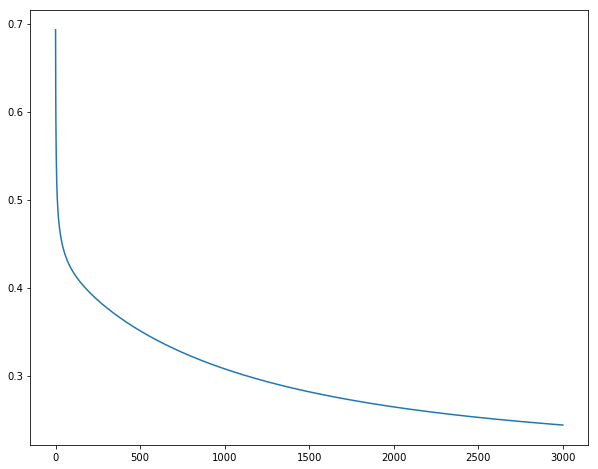

In [173]:
plt.plot(loss_array)

### Uber function to perform the entire operation
SO far I have been calling different functions to run gradient descent and get training accuracy and test accuracy. Hence instead of repeating code, I am going to encapsulate these operations in another function

In [174]:
def perceptron_model(x_train,y_train,x_test,y_test, iterations, learning_rate):
    params, loss_array = run_grad_desc(iterations,learning_rate,x_train, y_train, n_1 = 1)
    y_train_predict = fwd_prop(params["W1"],params["B1"],x_train,ytrain)
    y_train_predict[y_train_predict>=0.5] = 1
    y_train_predict[y_train_predict< 0.5] = 0
    accuracy = np.sum(y_train_predict == ytrain)/len(ytrain)
    print("Training Set Accuracy:-", accuracy)
    
    y_predict = fwd_prop(params["W1"],params["B1"],x_test,y_test)
    y_predict[y_predict>=0.5] = 1
    y_predict[y_predict< 0.5] = 0
    accuracy = np.sum(y_predict == y_test)/len(y_test)
    print("Test Set Accuracy:-", accuracy)

In [175]:
perceptron_model(x_train, ytrain, x_test,ytest,3000,0.005)

Training Set Accuracy:- 0.9095
Test Set Accuracy:- 0.9045


In [ ]:
# 

In [210]:
def show_cifar_samples(x,y,class_of_interest):
        number_of_samples = 7
        idclass = classes[class_of_interest]
        y_sample = np.where(y == idclass)
        
        y_idx = y_sample[0][1:number_of_samples]
        offset = 1

        for i in y_idx:

            plt.subplot(number_of_samples,number_of_samples,offset)
            plt.imshow(x[i].astype('uint8'))
            if(offset == 1):
                plt.title(class_of_interest)
            offset= offset + 1
            plt.axis('off')

        plt.show()

        y_otherclass = np.where(y!=idclass)
        y_idx = y_otherclass[0][1:number_of_samples]

        offset = 1
        fig, ax = plt.subplots(nrows = 1, ncols = number_of_samples)
        
        for i in y_idx:
            ax[i].plot()
            plt.imshow(x[i].astype('uint8'))
            plt.axis('off')

        plt.show()


In [192]:
def normalize(x):
        #Normalizing the vector
    mean_x = np.mean(x)
    stddev_x = np.std(x)
    x_output  = (x- mean_x) / stddev_x 
    
    return(x_output)

In [193]:
def generate_cifar_train_test_set(x, y, class_of_interest, show_samples = 0):
    if class_of_interest not in classes.keys():
        return("Error")
    
    else:
        idclass = classes[class_of_interest]
        
        if show_samples:
            show_cifar_samples(x,y,class_of_interest)

        
        x_dataset = x
        y_dataset = np.zeros(len(y))
        y_dataset[y == idclass] = 1
        
        xtrain, xtest, ytrain, ytest = train_test_split(x_dataset, y_dataset, test_size = 0.2)
        x_train_vector = xtrain.reshape(xtrain.shape[0],-1).T
        x_test_vector = xtest.reshape(xtest.shape[0],-1).T
        
        x_train = normalize(x_train_vector)
        
        #For normalizing test data, we will use the mean and std.dev from the training data (i.e not the mean and std.dev
        # from the test data)
        mean_x = np.mean(x_train_vector)
        stddev_x = np.std(x_train_vector)
        x_test = (x_test_vector - mean_x)/stddev_x
        
        
        return(x_train,ytrain,x_test,ytest)

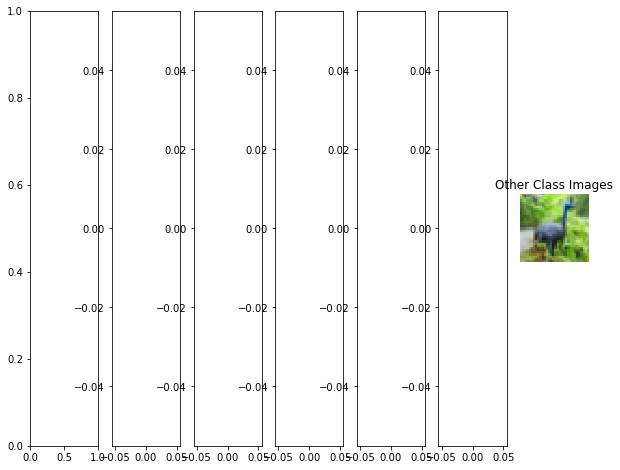

Training Set Accuracy:- 0.89825
Test Set Accuracy:- 0.997


In [211]:
class_of_interest = "truck"
truck_train, label_train, truck_test, label_test = generate_cifar_train_test_set(x, y, class_of_interest, show_samples = 1)
perceptron_model(truck_train, label_train, truck_test,label_test,4000,0.005)

In [186]:
np.shape(truck_train)

(3072, 8000)